## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 128, 64]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-2
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
# 載入 Callbacks
from tensorflow.keras.callbacks import EarlyStopping

earlystops = {}
earlystops['patience=10'] = EarlyStopping(monitor="val_loss", patience=10, verbose=1)
earlystops['patience=25'] = EarlyStopping(monitor="val_loss", patience=25, verbose=1)

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
hidden_layer3 (Dense)        (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256   

In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

model.save_weights('init_model.h5')
for key in earlystops.keys():
    model.load_weights('init_model.h5')
    model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[earlystops[key]]
         )
    
    # Collect results
    result = {}
    result["loss"] = model.history.history["loss"]
    result["val_loss"] = model.history.history["val_loss"]
    result["accuracy"] = model.history.history["accuracy"]
    result["val_accuracy"] = model.history.history["val_accuracy"]
    results[key] = result

W0720 18:07:14.747044  8652 deprecation.py:323] From c:\users\qwerz\miniconda3\envs\ml100\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 62us/sample - loss: 1.9029 - accuracy: 0.3462 - val_loss: 2.3336 - val_accuracy: 0.1540
Epoch 2/50
50000/50000 [==============================] - 2s 42us/sample - loss: 1.5758 - accuracy: 0.4426 - val_loss: 1.8436 - val_accuracy: 0.3347
Epoch 3/50
50000/50000 [==============================] - 2s 42us/sample - loss: 1.4715 - accuracy: 0.4797 - val_loss: 1.6577 - val_accuracy: 0.4142
Epoch 4/50
50000/50000 [==============================] - 2s 42us/sample - loss: 1.4013 - accuracy: 0.5056 - val_loss: 1.6188 - val_accuracy: 0.4202
Epoch 5/50
50000/50000 [==============================] - 2s 42us/sample - loss: 1.3438 - accuracy: 0.5253 - val_loss: 1.5284 - val_accuracy: 0.4574
Epoch 6/50
50000/50000 [==============================] - 2s 42us/sample - loss: 1.2970 - accuracy: 0.5417 - val_loss: 1.5287 - val_accuracy: 0.4543
Epoch 7/50
50000/50000 [==============================] 

Epoch 35/50
50000/50000 [==============================] - 2s 43us/sample - loss: 0.4894 - accuracy: 0.8297 - val_loss: 2.3338 - val_accuracy: 0.4495
Epoch 00035: early stopping




---------------- [ patience=10 ] ----------------


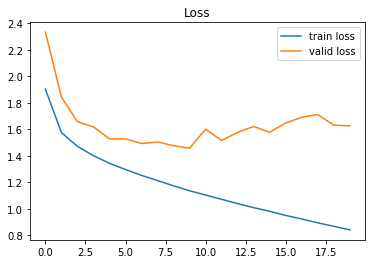

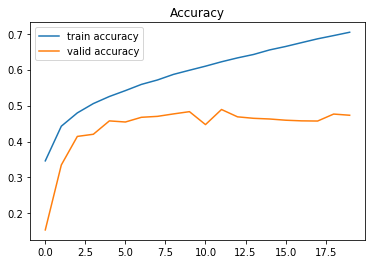



---------------- [ patience=25 ] ----------------


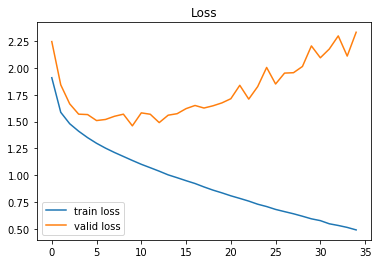

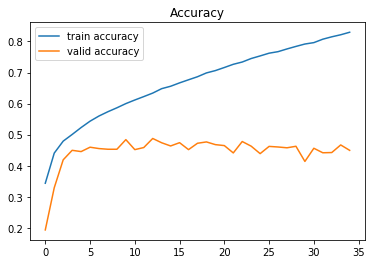

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
for key in results.keys():
    print("\n\n---------------- [ %s ] ----------------" % key)
    result = results[key]
    plt.plot(range(len(result["loss"])), result["loss"], label="train loss")
    plt.plot(range(len(result["val_loss"])), result["val_loss"], label="valid loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    plt.plot(range(len(result["accuracy"])), result["accuracy"], label="train accuracy")
    plt.plot(range(len(result["val_accuracy"])), result["val_accuracy"], label="valid accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.show()